___
# <font color= #d4b1e6> **Proyecto 1: Análisis de Sentimientos** </font>
- <Strong> Nombre de los integrantes: </Strong>  <font color="blue">`Sarah Lucía Beltrán, Priscila Cervantes Ramírez & Mónica Ibarra Herrera` </font>
- <Strong> Materia: </Strong>  <font color="blue">`Minería de Textos` </font>
___

A continuación se trabajará con un dataset que contiene reseñas de películas que están etiquetadas como positivas y negativas.

En este proyecto se implementarán y compararán modelos basados en n-grams (unigramas, bigramas y trigramas) enfocados en la clasificación de texto. El objetivo es evaluar cómo los diferentes tamaños de n-gramas influyen en el desempeño de los algoritmos que se emplearán. 

Los modelos que se incluirán son los siguientes:
- Regresión Logística 
- Naive Bayes
- SVM

Para cada uno de los modelos mencionados anteriormente se obtendrán diferentes métricas como Accuracy, Precision, Recall y F1-Score.

Se harán evaluaciones y se determinará cuál fue el modelo con el mejor desempeño, así como se revisarán algunos errores que hicieron los modelos para identificar por qué predijo mal, ya sea porque la reseña era de sarcasmo, negación, etc.

### <font color= #d4b1e6> **Librerías a utilizar** </font>

In [34]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix
)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import random

### <font color= #d4b1e6> **Importación de los datos** </font>

In [35]:
df = pd.read_csv('IMDB Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


*Visualizar que no haya valores nulos*

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


### <font color= #d4b1e6> **División train/test** </font>

In [37]:
train_df, test_df = train_test_split(df, test_size=0.5, random_state=42, stratify=df['sentiment'])

print("Tamaño train:", len(train_df))
print("Tamaño test:", len(test_df))


Tamaño train: 25000
Tamaño test: 25000


Se usarán el 50% es decir 25,000 reseñas para entrenar a los modelos y las reseñas restantes, se usarán para probar su rendimiento.

### <font color= #d4b1e6> **Pre-Procesamiento** </font>

In [38]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download("stopwords")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\cesar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\cesar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\cesar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Se utilizó la librería NLTK (Natural Language Toolkit) para realizar la tokenización del texto. Para ello fue necesario descargar los recursos *punkt*, *punkt_tab* y *stopwords*.

- *punkt* permite dividir de manera automática un texto en oraciones y palabras (tokens). 

- *punkt_tab* contiene información extra para que funcione de manera correcta el tokenizador.

- *stopwords* que contiene un listado de palabras muy frecuentes en el idioma (como the, is, and) que suelen eliminarse por no aportar valor al analizar texto.

De esta forma, se asegura que cada reseña se transforme en una secuencia de palabras significativas antes de construir representaciones con n-gramas.

*Limpieza de reseñas*

In [39]:
STOPWORDS = set(stopwords.words("english"))
PUNCT_TABLE = str.maketrans("", "", string.punctuation)

- *STOPWORDS* importa una lista de stopwords en inglés desde NLTK y las convierte en un conjunto para que las búsquedas sean más rápidas cuando se filtre texto.
- *PUNCT_TABLE* crea una tabla de traducción que sirve para eliminar todos los signos de puntuación, limpia el texto quitando las puntuaciones.

In [40]:
def preprocess_text(text, remove_stopwords=False):
    # Minúsculas
    text = text.lower()
    # Eliminar HTML
    text = re.sub(r"<.*?>", " ", text)
    # Tokenizar
    tokens = word_tokenize(text)
    # Eliminar tokens que no son alfanuméricos
    tokens = [t for t in tokens if any(c.isalnum() for c in t)]
    # Eliminar stopwords si se requiere
    if remove_stopwords:
        tokens = [t for t in tokens if t not in STOPWORDS]
    return " ".join(tokens)

# Aplicamos a train y test
train_df["clean_review"] = train_df["review"].apply(lambda x: preprocess_text(x, remove_stopwords=False))
test_df["clean_review"] = test_df["review"].apply(lambda x: preprocess_text(x, remove_stopwords=False))

train_df.head()

,review,sentiment,clean_review
3055,Trio's vignettes were insightful and quite enj...,positive,trio 's vignettes were insightful and quite en...
47326,I had never heard of this one before the owner...,negative,i had never heard of this one before the owner...
48869,This is an excellent but hard to find trippy W...,positive,this is an excellent but hard to find trippy w...
48623,"I am a huge fan of big, loud, trashy, complete...",positive,i am a huge fan of big loud trashy completely ...
39657,"Easily Lucio Fulci's most respected film, ""Don...",positive,easily lucio fulci 's most respected film do n...


Se implementa una función de preprocesamiento de texto que:

1) Convierte todo a minúsculas.

2) Elimina etiquetas HTML.

3) Tokeniza las reseñas en palabras individuales.

4) Filtra tokens que no son letras o números como signos de puntuación

5) Opcionalmente elimina stopwords.

Se decidió no eliminar las stopwords durante el preprocesamiento, ya que en análisis de sentimientos estas palabras pueden cambiar el significado de una oración. Palabras como ‘not’, ‘never’ o ‘don’t’ son esenciales para que el modelo identifique correctamente si la reseña es positiva o negativa. 

De esta manera, se obtiene una columna clean_review con texto más limpio y normalizado, que facilita el posterior análisis y entrenamiento del modelo de clasificación.

*Extracción de características*

In [41]:
# Ejemplo con unigramas
vectorizer_uni = CountVectorizer(ngram_range=(1,1), max_features=50000)
X_train_uni = vectorizer_uni.fit_transform(train_df["clean_review"])
X_test_uni = vectorizer_uni.transform(test_df["clean_review"])

y_train_uni = train_df["sentiment"]
y_test_uni = test_df["sentiment"]

# Ejemplo con bigramas
vectorizer_bi = CountVectorizer(ngram_range=(2,2), max_features=50000)
X_train_bi = vectorizer_bi.fit_transform(train_df["clean_review"])
X_test_bi = vectorizer_bi.transform(test_df["clean_review"])

y_train_bi = train_df["sentiment"]
y_test_bi = test_df["sentiment"]


# Ejemplo con trigramas
vectorizer_tri = CountVectorizer(ngram_range=(3,3), max_features=50000)
X_train_tri = vectorizer_tri.fit_transform(train_df["clean_review"])
X_test_tri = vectorizer_tri.transform(test_df["clean_review"])

y_train_tri = train_df["sentiment"]
y_test_tri = test_df["sentiment"]

Para representar las reseñas se utilizó un CountVectorizer de Scikit-learn para extraer unigramas, bigramas y trigramas. Esto significa que cada reseña se transforma en un vector que refleja la frecuencia de palabras individuales y combinaciones de dos o tres palabras consecutivas. Se limitó el vocabulario a 50,000 características para reducir el consumo de memoria.

El vectorizador se ajusta al conjunto de entrenamiento y luego se aplica al conjunto de prueba usando el mismo vocabulario aprendido, asegurando que la evaluación sea consistente. Las etiquetas de sentimiento se almacenan por separado en y_train y y_test, y las dimensiones de las matrices resultantes reflejan el número de reseñas y la cantidad de n-gramas considerados.

### <font color= #d4b1e6> **Entrenamiento de Modelos** </font> 

#### <font color= #96d9cf> **Regresión Logística** </font> 

**Unigramas**

In [42]:
logreg_uni = LogisticRegression(max_iter=1000, solver="saga")
logreg_uni.fit(X_train_uni, y_train_uni)
y_pred_logreg_uni = logreg_uni.predict(X_test_uni)

c:\Users\cesar\anaconda3\envs\iteso\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


**Bigramas**

In [43]:
logreg_bi = LogisticRegression(max_iter=1000, solver="saga")
logreg_bi.fit(X_train_bi, y_train_bi)
y_pred_logreg_bi = logreg_bi.predict(X_test_bi)

c:\Users\cesar\anaconda3\envs\iteso\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


**Trigramas**

In [44]:
logreg_tri = LogisticRegression(max_iter=1000, solver="saga")
logreg_tri.fit(X_train_tri, y_train_tri)
y_pred_logreg_tri = logreg_tri.predict(X_test_tri)

c:\Users\cesar\anaconda3\envs\iteso\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


*Explicación de hiperparámetros*

Para entrenar el modelo de Regresión Logística se utilizó LogisticRegression de Scikit-learn con los hiperparámetros max_iter=1000 y solver="saga".

- *max_iter* de 1000 para asegurar que el algoritmo converja, dado el tamaño y la alta dimensionalidad de los datos de n-grams.

- *solver="saga"* fue elegido por su eficiencia con matrices dispersas y por su capacidad de manejar regularización L1 y L2, características útiles para textos con muchas características.

#### <font color= #96d9cf> **Naive Bayes** </font>

**Unigramas**

In [45]:
nb_uni = MultinomialNB()
nb_uni.fit(X_train_uni, y_train_uni)
y_pred_nb_uni = nb_uni.predict(X_test_uni)

**Bigramas**

In [46]:
nb_bi = MultinomialNB()
nb_bi.fit(X_train_bi, y_train_bi)
y_pred_nb_bi = nb_bi.predict(X_test_bi)

**Trigramas**

In [47]:
nb_tri = MultinomialNB()
nb_tri.fit(X_train_tri, y_train_tri)
y_pred_nb_tri = nb_tri.predict(X_test_tri)


Se entrenó un modelo Naive Bayes multinomial para clasificar las reseñas en positivas o negativas. Este modelo es adecuado para datos de conteo, como los vectores de n-grams, ya que estima la probabilidad de cada palabra dado el sentimiento de la reseña.

#### <font color= #96d9cf> **SVM** </font>

**Unigramas**

In [48]:
svm_uni = LinearSVC(C=0.001)
svm_uni.fit(X_train_uni, y_train_uni)
y_pred_svm_uni = svm_uni.predict(X_test_uni)

**Bigramas**

In [49]:
svm_bi = LinearSVC(C=0.001)
svm_bi.fit(X_train_bi, y_train_bi)
y_pred_svm_bi = svm_bi.predict(X_test_bi)

**Trigramas**

In [50]:
svm_tri = LinearSVC(C=0.001)
svm_tri.fit(X_train_tri, y_train_tri)
y_pred_svm_tri = svm_tri.predict(X_test_tri)

Se utilizó Support Vector Machine Lineal, adecuado para matrices dispersas de alta dimensionalidad como las obtenidas con n-grams. 

*Explicación de hiperparámetros*:

- C: controla la regularización y penalización de errores.


### <font color= #d4b1e6> **Evaluación** </font> 

In [ ]:
def evaluar_modelo(nombre, y_true, y_pred):
    return {
        "Modelo": nombre,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, average="macro"),
        "Recall": recall_score(y_true, y_pred, average="macro"),
        "F1-Score": f1_score(y_true, y_pred, average="macro")
    }

In [52]:
def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred, labels=["positive", "negative"])
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["positive", "negative"],
                yticklabels=["positive", "negative"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.show()

#### <font color= #96d9cf> **Regresión Logística** </font> 

In [ ]:
resultados = []

resultados.append(evaluar_modelo("LogReg Unigramas", y_test_uni, y_pred_logreg_uni))
resultados.append(evaluar_modelo("LogReg Bigramas", y_test_bi, y_pred_logreg_bi))
resultados.append(evaluar_modelo("LogReg Trigramas", y_test_tri, y_pred_logreg_tri))

df_resultados = pd.DataFrame(resultados)
df_resultados = df_resultados.sort_values(by="F1-Score", ascending=False).reset_index(drop=True)

print(df_resultados)


             Modelo  Accuracy  Precision   Recall  F1-Score
0  LogReg Unigramas   0.89052   0.890559  0.89052  0.890517
1   LogReg Bigramas   0.87860   0.878620  0.87860  0.878598
2  LogReg Trigramas   0.83244   0.832613  0.83244  0.832418


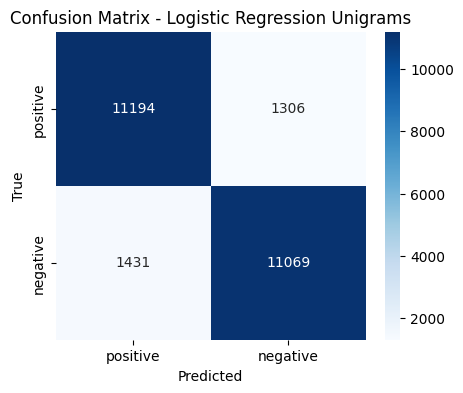

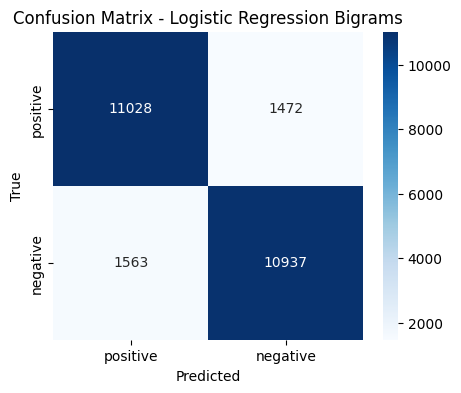

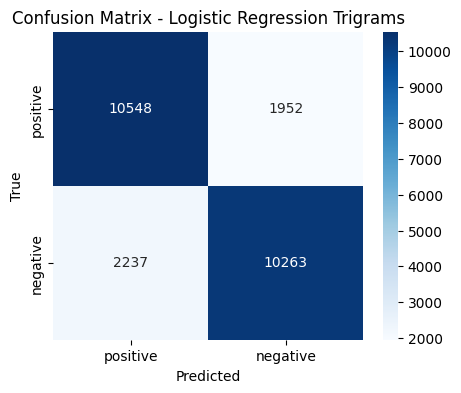

In [54]:
plot_confusion(y_test_uni, y_pred_logreg_uni, "Confusion Matrix - Logistic Regression Unigrams")
plot_confusion(y_test_bi, y_pred_logreg_bi, "Confusion Matrix - Logistic Regression Bigrams")
plot_confusion(y_test_tri, y_pred_logreg_tri, "Confusion Matrix - Logistic Regression Trigrams")

#### <font color= #96d9cf> **Naive Bayes** </font>

In [ ]:
resultados = []

resultados.append(evaluar_modelo("Naive Bayes Unigramas", y_test_uni, y_pred_nb_uni))
resultados.append(evaluar_modelo("Naive Bayes Bigramas", y_test_bi, y_pred_nb_bi))
resultados.append(evaluar_modelo("Naive Bayes Trigramas", y_test_tri, y_pred_nb_tri))

df_resultados = pd.DataFrame(resultados)
df_resultados = df_resultados.sort_values(by="F1-Score", ascending=False).reset_index(drop=True)

print(df_resultados)

                  Modelo  Accuracy  Precision   Recall  F1-Score
0   Naive Bayes Bigramas   0.87484   0.874871  0.87484  0.874837
1  Naive Bayes Trigramas   0.85724   0.857512  0.85724  0.857213
2  Naive Bayes Unigramas   0.84212   0.843353  0.84212  0.841978


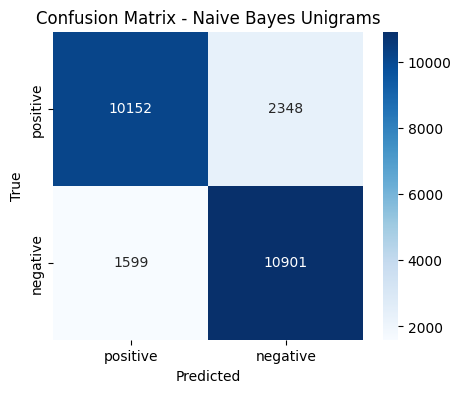

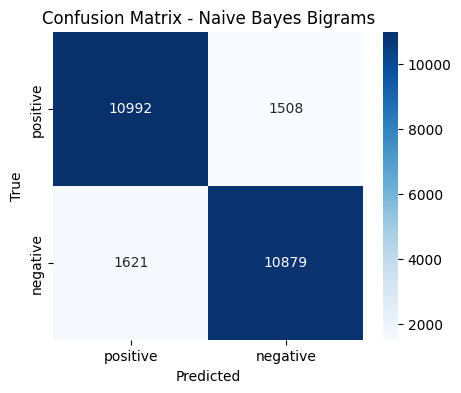

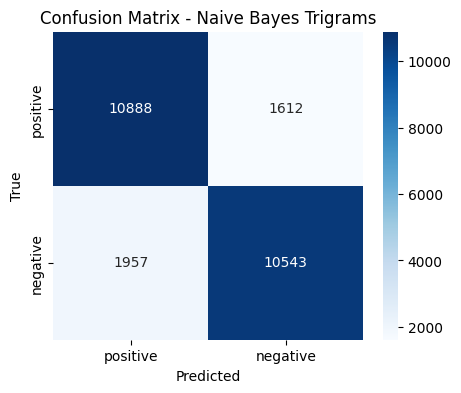

In [56]:
plot_confusion(y_test_uni, y_pred_nb_uni, "Confusion Matrix - Naive Bayes Unigrams")
plot_confusion(y_test_bi, y_pred_nb_bi, "Confusion Matrix - Naive Bayes Bigrams")
plot_confusion(y_test_tri, y_pred_nb_tri, "Confusion Matrix - Naive Bayes Trigrams")

#### <font color= #96d9cf> **SVM** </font>

In [ ]:
resultados = []

resultados.append(evaluar_modelo("SVM Unigramas", y_test_uni, y_pred_svm_uni))
resultados.append(evaluar_modelo("SVM Bigramas", y_test_bi, y_pred_svm_bi))
resultados.append(evaluar_modelo("SVM Trigramas", y_test_tri, y_pred_svm_tri))

df_resultados = pd.DataFrame(resultados)
df_resultados = df_resultados.sort_values(by="F1-Score", ascending=False).reset_index(drop=True)

print(df_resultados)

          Modelo  Accuracy  Precision   Recall  F1-Score
0  SVM Unigramas   0.88628   0.886424  0.88628  0.886269
1   SVM Bigramas   0.87168   0.872073  0.87168  0.871646
2  SVM Trigramas   0.81008   0.811562  0.81008  0.809854


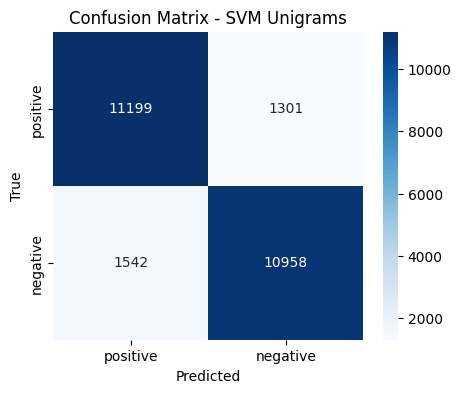

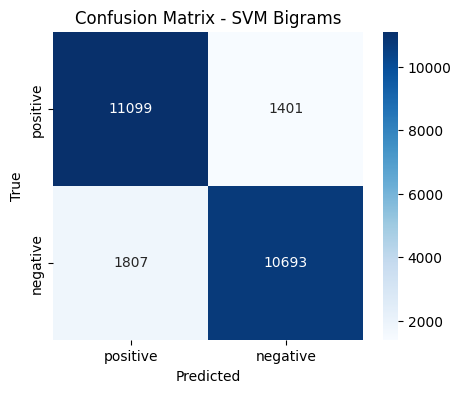

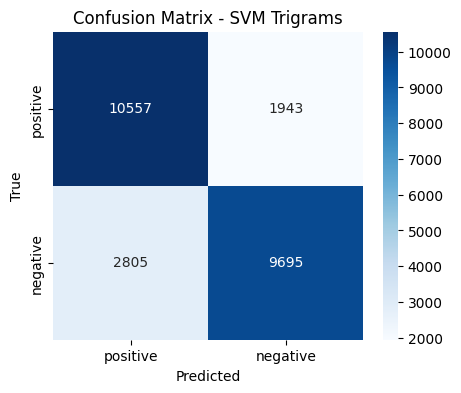

In [58]:
plot_confusion(y_test_uni, y_pred_svm_uni, "Confusion Matrix - SVM Unigrams")
plot_confusion(y_test_bi, y_pred_svm_bi, "Confusion Matrix - SVM Bigrams")
plot_confusion(y_test_tri, y_pred_svm_tri, "Confusion Matrix - SVM Trigrams")

### <font color= #d4b1e6> **Comparación de resultados** </font> 

| Modelo | Accuracy | F1-Score | Precision | Recall |
|------------|-------|-------|------|--------|
| Regresión logística Unigramas|0.89|0.89|0.89| 0.89| 
| Regresión logística Bigramas|0.87|0.87|0.87| 0.87| 
| Regresión logística Trigramas|0.83|0.83|0.83| 0.83| 
| Naive Bayes Unigramas|0.87|0.87|0.87|0.87|   
| Naive Bayes Bigramas|0.85|0.85|0.85|0.85|
| Naive Bayes Trigramas|0.84|0.84|0.84|0.84| 
| SVM Unigramas|0.88|0.88|0.88|0.88|
| SVM Bigramas|0.87|0.87|0.87|0.87|
| SVM Trigramas|0.81|0.81|0.81|0.80|

Analizando los resultados podemos ver que el obtuvo mejor métricas fue la Regresión Logística con Unigramas.

También podemos observar que los modelos entrenados con trigramas tuvieron un desempeño ligeramente inferior en comparación con los unigramas y bigramas. Esto se debe a que los trigramas generan vectores de características mucho más dispersos. Además, los trigramas son más específicos, lo que aumenta la probabilidad de sobreajuste a patrones raros del conjunto de entrenamiento que no se repiten en el conjunto de prueba. Por estas razones, aunque los trigramas capturan un contexto más amplio, no siempre tienen un mejor desempeño, y en nuestro caso los modelos con unigramas y bigramas mostraron métricas más altas de precisión y F1-score.

### <font color= #d4b1e6> **Análisis de Error** </font> 

A continuación se hará un análisis de error para determinar por qué el modelo predijo que la reseña era negativa cuando en realidad era positiva o viceversa.

Lo haremos con el modelo que mejor rendimiento tuvo, el cual fue Regresión Logística con unigramas.

Haremos el análisis con 5 ejemplos para determinar en dódnde está fallando el modelo y concluir si no detecta bien el sarcasmo, ironía, negación, etc.

In [60]:
# Escogemos un modelo para analizar (ej. Logistic Regression)
y_pred = y_pred_logreg_uni  

# Encuentra índices de errores
errores_idx = [i for i, (y_true, y_hat) in enumerate(zip(y_test_uni, y_pred)) if y_true != y_hat]

print("Total errores:", len(errores_idx))

# Muestra algunos ejemplos al azar usando el texto original
for i in random.sample(errores_idx, 5):
    print("="*80)
    print("🔹 Review original:")
    print(test_df.iloc[i]["review"])   # aquí usamos test_df, no X_test
    print("Sentiment real:", test_df.iloc[i]["sentiment"])
    print("Predicción modelo:", y_pred[i])

Total errores: 2737
🔹 Review original:
I'm not going to lie and say I don't watch the show--I do. BUT it has a lot, and a lot of flaws. 1) The Boarding School is perfect. The drama is at a minimum. Everyone is so nice to each other, you know. Lets give that a reality check. Its IMPOSSIBLE that ANY school is perfect like PCA. Free laptops for everyone. Big dorm rooms. Mini fridges. If there was a school like that in real life, almost nobody there would be a virgin for one. Two, everyone there is so rich, and its weird how nobody has anything stolen yet. 2) Characters really unrealistic. First things first, who in they're right minds talk like they do. They talk like a perfect teenager would. Secondly, Logan Reese(Matthew Underwood) is an extremely rich boy "hot" teenage boy. My question is, why isn't almost ever girl in that school all over him? He's rich and "hot" now a days all those girls would be after him, even if he was a jerk. Also, Chase is the most stupidest person ever. He is 

- En el primer ejemplo, el modelo predijo que era una reseña positiva cuando en realidad era negativa. En la reseña aparecen palabras como perfect, nice, free, big y hot, que normalmente se asocian a un sentimiento positivo. Sin embargo, muchas de estas palabras se usan de manera sarcástica o irónica, por ejemplo: “The Boarding School is perfect” y “Everyone is so nice to each other” son críticas disfrazadas de elogios.

- En el segundo ejemplo, el modelo predijo que era una reseña negativa cuando era positiva. En la reseña aparecen palabras como difficult situation, low scores, sorry, por lo que el modelo predijo negativo porque se basó en estas palabras con connotación negativa y no pudo interpretar que la reseña era positiva de manera un poco indirecta.

- En el tercer ejemplo donde predijo que era positiva cuando era negativa, se debe a que se centró en palabras positivas asociadas a otros episodios, sin interpretar el contexto ni la ironía.

- En el cuarato ejemplo donde era negativa pero el modelo predijo negativo, es porque se basó en palabras aisladas con connotación positiva o neutra que aparecen a lo largo de la explicación, sin entender el contexto ni la crítica central. Este error muestra que los modelos de Unigramas no pueden manejar reseñas largas con explicaciones difíciles, negaciones o sarcasmo implícito, y tienden a ser engañados por palabras positivas.

- En el último ejemplo, predijo que era negativo cuando en realidad es positivo, porque se basó en palabras con connotación negativa presentes en la descripción de la trama, sin interpretar que el sentimiento era positivo. Este caso muestra otra limitación de los modelos de n-gramas los cuales confunden violencia, miedo o palabras dramáticas de la historia con críticas negativas.

### <font color= #d4b1e6> **Conclusiones** </font> 

Aunque el modelo que mejor desempeño tuvo fue el de Rgeresión Logística con n-gramas, analizando los errores nos pudimos dar cuenta de las limitaciones que tiene, como por ejemplo cuando hay negación, ironía, sarcasmo, violencia.

Los errores en la predicción se daban gracias a que le daba peso a las palabras negativas dentro de reseñas positivas, aunque solo se usen para describir escenas, personajes o incluso a la misma aplicación. Otro error, que va de la mano con el anterior, es que se deja guiar por las primeras palabras que hay en la reseña, por esto si una reseña empieza diciendo lo bueno para acabar diciendo que es la peor película, el modelo no lo terminará de entender. 

También nos percatamos que cuando en una reseña existe ironía no logra comprenderla, asi como no distingue sentimientos hacia la película con los elementos externos. En pocas palabras, el modelo analizaba superficialmente el texto en vez de comprender la intención completa del autor.